# Pneumonia Image Classification 

## Business Understanding:

In this image classification project, I am utilizing neural networks - primarily convolutional neural networks - to create a model that can identify whether or not a patient has pneumonia by analyzing their lung x-rays. 

There are two types of pneumonia - bacterial and viral. The image classification system will have to be able to pick out both, while not necessarily knowing which one is which, as the types of pneumonia are not labeled in the dataset. 



## Data Understanding:
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. 

Due to the relatively small amount of validation data (16 images), as well as test data, I will create my own validation data instead of using the provided split.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
import tensorflow as tf
from keras import models
from keras import layers
import pathlib
import PIL
import seaborn as sns
import time
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import random
import glob
import os
import sys
import itertools
import warnings
import statistics

## Define Scoring Metric
For the purposes of this analysis, I think a custom scoring metric is necessary. 

My reasoning is this:
- False negatives could cause patients with pneumonia to not recieve further testing. This would be the worst possibility, out of the options. 
- False positives would cost more due to testing people who did not actually have pneumonia, or could cause people without pneumonia to needlessly worry about their health. This is also costly, but not as costly as mis-diagnosing an individual with pneumonia. 

Thus, I want to minimize false negatives while keeping false positives to an appropriate level.  


According to https://towardsdatascience.com/performance-metrics-confusion-matrix-precision-recall-and-f1-score-a8fe076a2262, the F1 score gives the same weightage to recall and precision, BUT there is a weighted F1 score in which we can give different weightage to recall and precision. As discussed in the previous section, different problems give different weightage to recall and precision.

F_B = (1+B^2) * [(Precision * Recall) / ((B^2 * Precision) + Recall)]

Beta represents how many times recall is more important than precision. If the recall is twice as important as precision, the value of Beta is 2.

Thus, for the purpose of this project, my Weighted F1 score will be:

F_B = (1+3^2) * [(Precision * Recall) / ((3^2 * Precision) + Recall)]

## Check Data

In [2]:
train_norm_size = len(os.listdir('re-split_data/train/normal'))
train_pneum_size = len(os.listdir('re-split_data/train/pneumonia'))
test_norm_size = len(os.listdir('re-split_data/test/normal'))
test_pneum_size = len(os.listdir('re-split_data/test/pneumonia'))
valid_norm_size = len(os.listdir('re-split_data/validation/normal'))
valid_pneum_size = len(os.listdir('re-split_data/validation/pneumonia'))


train_size = train_norm_size + train_pneum_size -1
test_size = test_norm_size + test_pneum_size -1
validation_size = valid_norm_size + valid_pneum_size

print(f' There are {train_size} images in the training set, {test_size} in the test set, and {validation_size} in the validation set')

print(f'train norm is {train_norm_size}')
print(f'train pneum is {train_pneum_size}')
print(f'test norm: {test_norm_size}')
print(f'test pneum: {test_pneum_size}')
print(f'valid norm: {valid_norm_size}')
print(f'valid pneum: {valid_pneum_size}')


 There are 3272 images in the training set, 1752 in the test set, and 816 in the validation set
train norm is 883
train pneum is 2390
test norm: 473
test pneum: 1280
valid norm: 220
valid pneum: 596


### Add Functions

In [3]:
# Define Result Saving Initial Function
dfcols = ['Model', 'RW Score', 'F1', 'Recall', 'Precision', 'Accuracy']
model_summary = pd.DataFrame(columns=dfcols)


def save_result(cf, model_name):
            global model_summary
            accuracy  = np.trace(cf) / float(np.sum(cf))
            recall = cf[1,1] / sum(cf[:,1])
            precision    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            beta = 9 # 3^2
            rw_score = (1+beta) * ((precision * recall) / ((beta * precision) + recall))

            #cv_std = statistics.stdev([cv1, cv2, cv3, cv4, cv5])
            #cv_avg = (cv1 + cv2 + cv3 + cv4 + cv5) / 5
            results_columns = ['Model', 'RW Score', 'F1', 'Recall', 'Precision', 'Accuracy']
            row = [(model_name, rw_score, f1_score, recall, precision, accuracy)]
            res = pd.DataFrame(columns = results_columns, data = row)
            yeep = [model_summary, res]
            model_summary = pd.concat(yeep)
            model_summary = model_summary.sort_values('Accuracy', ascending = False)
            model_summary = model_summary.drop_duplicates()
            return model_summary.round(3)

In [4]:
# 1. Confusion Matrix
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            recall = cf[1,1] / sum(cf[:,1])
            precision    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            beta = 9
            rw_score = (1+beta) * ((precision * recall) / ((beta * precision) + recall))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\nRW Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rw_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

### Re-Splitting (Hide)

#### Check re-aggregated images

Due to the issues with the given train/test split, i re-aggregated the images. From here, I will train/test split the data myself. 

In [5]:
'''
folder = 're-split_data/NORMAL'
path = folder
p = os.listdir(path)
pf = pd.DataFrame(p)
norm_tot = len(pf)

folder = 're-split_data/PNEUMONIA'
path = folder
p = os.listdir(path)
pf = pd.DataFrame(p)
pneum_tot = len(pf)
pneum_weight = len(pf) / 5863
norm_weight = 1 - pneum_weight

print(f' There are {len(pf[0])} images in the pneumonia folder')
print(f' there are {1576 + len(pf[0])} total images in the dataset')
print(f' The weight of pneumonia is {round(pneum_weight,2)}')
print(f' The weight of normal is {round(norm_weight,2)}')

'''

"\nfolder = 're-split_data/NORMAL'\npath = folder\np = os.listdir(path)\npf = pd.DataFrame(p)\nnorm_tot = len(pf)\n\nfolder = 're-split_data/PNEUMONIA'\npath = folder\np = os.listdir(path)\npf = pd.DataFrame(p)\npneum_tot = len(pf)\npneum_weight = len(pf) / 5863\nnorm_weight = 1 - pneum_weight\n\nprint(f' There are {len(pf[0])} images in the pneumonia folder')\nprint(f' there are {1576 + len(pf[0])} total images in the dataset')\nprint(f' The weight of pneumonia is {round(pneum_weight,2)}')\nprint(f' The weight of normal is {round(norm_weight,2)}')\n\n"

From here, there is some code which I used to re-split the data.

In [6]:
# define test and train split percentages
'''
norm_train = norm_tot * .7
norm_test = norm_tot * .3
pneum_train = pneum_tot * .7
pneum_test = pneum_tot * .3
'''

'''
pf = os.listdir('re-split_data/NORMAL')
rand_norm_files = random.sample(pf, int(norm_train))
for file in rand_norm_files:
    shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/train/normal')
'''

"\npf = os.listdir('re-split_data/NORMAL')\nrand_norm_files = random.sample(pf, int(norm_train))\nfor file in rand_norm_files:\n    shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/train/normal')\n"

In [7]:
'''
p1 = os.listdir('re-split_data/train/normal')
p1 = pd.DataFrame(p1)

p2 = os.listdir('re-split_data/NORMAL')
p2 = pd.DataFrame(p2)

tester_files = pd.concat([p1[0],p2[0]]).drop_duplicates(keep=False)
'''

"\np1 = os.listdir('re-split_data/train/normal')\np1 = pd.DataFrame(p1)\n\np2 = os.listdir('re-split_data/NORMAL')\np2 = pd.DataFrame(p2)\n\ntester_files = pd.concat([p1[0],p2[0]]).drop_duplicates(keep=False)\n"

In [8]:
#for file in tester_files:
    #shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/test/normal')

In [9]:
'''
# The pneumonia files
pf = os.listdir('re-split_data/PNEUMONIA')

rand_Pfiles = random.sample(pf, int(pneum_train))

for file in rand_Pfiles:
    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/train/pneumonia')

p3 = os.listdir('re-split_data/train/pneumonia')
p3 = pd.DataFrame(p3)

p4 = os.listdir('re-split_data/PNEUMONIA')
p4 = pd.DataFrame(p4)

tester_p =  pd.concat([p3[0],p4[0]]).drop_duplicates(keep=False)

for file in tester_p:
    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/test/pneumonia')
'''

"\n# The pneumonia files\npf = os.listdir('re-split_data/PNEUMONIA')\n\nrand_Pfiles = random.sample(pf, int(pneum_train))\n\nfor file in rand_Pfiles:\n    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/train/pneumonia')\n\np3 = os.listdir('re-split_data/train/pneumonia')\np3 = pd.DataFrame(p3)\n\np4 = os.listdir('re-split_data/PNEUMONIA')\np4 = pd.DataFrame(p4)\n\ntester_p =  pd.concat([p3[0],p4[0]]).drop_duplicates(keep=False)\n\nfor file in tester_p:\n    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/test/pneumonia')\n"

#### Validation Files

Make a validation set from the train set

In [10]:
'''
pf = os.listdir('re-split_data/train/normal')
norm_tot = len(pf)
pf1 = os.listdir('re-split_data/train/pneumonia')
pneum_tot = len(pf1)

print(f' There are {norm_tot} images in the normal training folder and {pneum_tot} in the pneumonia training folder')
'''

"\npf = os.listdir('re-split_data/train/normal')\nnorm_tot = len(pf)\npf1 = os.listdir('re-split_data/train/pneumonia')\npneum_tot = len(pf1)\n\nprint(f' There are {norm_tot} images in the normal training folder and {pneum_tot} in the pneumonia training folder')\n"

In [11]:
'''
pf2 = os.listdir('re-split_data/validation/normal')
valid_norm_tot = len(pf2)
pf3 = os.listdir('re-split_data/validation/pneumonia')
valid_pneum_tot = len(pf3)

rand_sample_valid_norm = random.sample(pf2, 110)
rand_sample_valid_pneum = random.sample(pf3, 298)

for file in rand_sample_valid_norm:
    shutil.move('re-split_data/validation/normal/' + file, 're-split_data/train/normal')

for file in rand_sample_valid_pneum:
    shutil.move('re-split_data/validation/pneumonia/' + file, 're-split_data/train/pneumonia')
    
'''

"\npf2 = os.listdir('re-split_data/validation/normal')\nvalid_norm_tot = len(pf2)\npf3 = os.listdir('re-split_data/validation/pneumonia')\nvalid_pneum_tot = len(pf3)\n\nrand_sample_valid_norm = random.sample(pf2, 110)\nrand_sample_valid_pneum = random.sample(pf3, 298)\n\nfor file in rand_sample_valid_norm:\n    shutil.move('re-split_data/validation/normal/' + file, 're-split_data/train/normal')\n\nfor file in rand_sample_valid_pneum:\n    shutil.move('re-split_data/validation/pneumonia/' + file, 're-split_data/train/pneumonia')\n    \n"

## Generate Test and Train Images

In [12]:
# get all the data in the directory split/test , and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/train',
        target_size=(64, 64), batch_size = train_size) 

test_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/test',
        target_size=(64, 64), batch_size = test_size, shuffle= False) 

valid_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/validation',
        target_size=(64, 64), batch_size = validation_size)

Found 3272 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [13]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
valid_images, valid_labels = next(valid_generator)

In [185]:
train_labels2 = pd.DataFrame(train_labels)
train_labels2

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
3267,0.0,1.0
3268,0.0,1.0
3269,0.0,1.0
3270,0.0,1.0


In [186]:
train_labels2[0].sum()

882.0

In [187]:
train_labels2[1].sum()

2390.0

This shows us that if column '0' equals 1, it is a NORMAL label. 

In [14]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

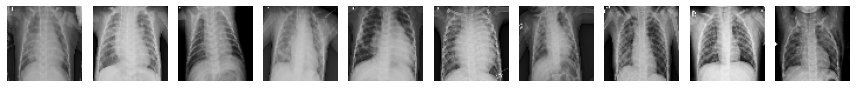

In [15]:
show_images(train_images)

In [16]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
valid_img = valid_images.reshape(valid_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(valid_img.shape)

(3272, 12288)
(1752, 12288)
(816, 12288)


In [17]:
train_y = np.reshape(train_labels[:,0], (train_size,1))
test_y = np.reshape(test_labels[:,0], (test_size,1))
valid_y = np.reshape(valid_labels[:,0], (validation_size,1))

print(train_y.shape)
print(test_y.shape)
print(valid_y.shape)

(3272, 1)
(1752, 1)
(816, 1)


## Baseline Model

In [18]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/15
103/103 [==============================] - 8s 75ms/step - loss: 0.6268 - accuracy: 0.6886
Epoch 2/15
103/103 [==============================] - 9s 86ms/step - loss: 0.5197 - accuracy: 0.7460
Epoch 3/15
103/103 [==============================] - 8s 80ms/step - loss: 0.4422 - accuracy: 0.8035
Epoch 4/15
103/103 [==============================] - 8s 77ms/step - loss: 0.3498 - accuracy: 0.8487
Epoch 5/15
103/103 [==============================] - 8s 77ms/step - loss: 0.2971 - accuracy: 0.8808
Epoch 6/15
103/103 [==============================] - 8s 78ms/step - loss: 0.2677 - accuracy: 0.8936
Epoch 7/15
103/103 [==============================] - 8s 78ms/step - loss: 0.2699 - accuracy: 0.8939
Epoch 8/15
103/103 [==============================] - 8s 76ms/step - loss: 0.2395 - accuracy: 0.9083
Epoch 9/15
103/103 [==============================] - 8s 79ms/step - loss: 0.2274 - accuracy: 0.9098
Epoch 10/15
103/103 [==============================] - 8s 79ms/step - loss: 0.2215 - accura

<AxesSubplot:>

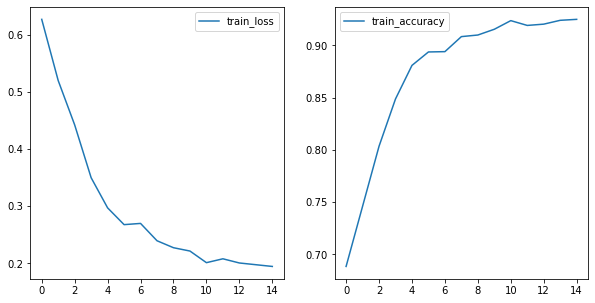

In [19]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline = model.fit(train_img, train_y,epochs=15, batch_size=32) 

train_loss = baseline.history['loss']
train_acc = baseline.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=baseline.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=baseline.epoch, y=train_acc, ax=ax2, label='train_accuracy')

### SkLearn Version for Cross-Validation

In [20]:
# Build function that builds the model so we can evaluate in sklearn
def build_model():
    model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [21]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=15,
                                          batch_size=32,
                                          verbose=2)

### Results

In [22]:
results_train = model.evaluate(train_img, train_y)

103/103 [==============================] - 8s 74ms/step - loss: 0.1566 - accuracy: 0.9428


In [23]:
results_test = model.evaluate(test_img, test_y)

55/55 [==============================] - 4s 74ms/step - loss: 0.1946 - accuracy: 0.9229


In [24]:
predictions = model.predict(x = test_img, verbose=0)

In [25]:
pred_check = np.round(predictions)

In [26]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [27]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [28]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [29]:
save_result(cm, 'baseline_model')

,Model,RW Score,F1,Recall,Precision,Accuracy
0,baseline_model,0.861,0.856,0.863,0.85,0.923


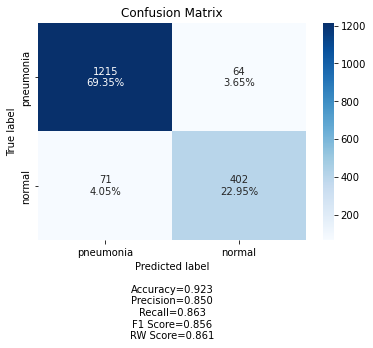

In [30]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

## Convolutional Neural Network (CNN) #1

In [31]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

### Train Initial Simple CNN

In [34]:
cnn_1 = model.fit(train_images,
                    train_y,
                    epochs=25,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/25
103/103 [==============================] - 16s 154ms/step - loss: 0.5929 - accuracy: 0.7304 - val_loss: 0.5820 - val_accuracy: 0.7304
Epoch 2/25
103/103 [==============================] - 16s 153ms/step - loss: 0.5725 - accuracy: 0.7304 - val_loss: 0.5572 - val_accuracy: 0.7304
Epoch 3/25
103/103 [==============================] - 16s 152ms/step - loss: 0.5404 - accuracy: 0.7304 - val_loss: 0.4996 - val_accuracy: 0.7304
Epoch 4/25
103/103 [==============================] - 15s 145ms/step - loss: 0.4832 - accuracy: 0.7781 - val_loss: 0.3968 - val_accuracy: 0.8542
Epoch 5/25
103/103 [==============================] - 15s 149ms/step - loss: 0.4038 - accuracy: 0.8188 - val_loss: 0.3631 - val_accuracy: 0.8076
Epoch 6/25
103/103 [==============================] - 16s 158ms/step - loss: 0.3394 - accuracy: 0.8579 - val_loss: 0.4914 - val_accuracy: 0.7647
Epoch 7/25
103/103 [==============================] - 17s 166ms/step - loss: 0.2759 - accuracy: 0.8854 - val_loss: 0.2383 - val_ac

In [35]:
results_train = model.evaluate(train_images, train_y)

103/103 [==============================] - 4s 40ms/step - loss: 0.1364 - accuracy: 0.9474


In [36]:
results_test = model.evaluate(test_images, test_y)

55/55 [==============================] - 2s 35ms/step - loss: 0.1803 - accuracy: 0.9309


### Prediction for Confusion Matrix

In [37]:
predictions = model.predict(x = test_images, steps = 10, verbose=0)

In [38]:
pred_check = np.round(predictions)

In [39]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [40]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [41]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

### CNN #1 Results



<AxesSubplot:>

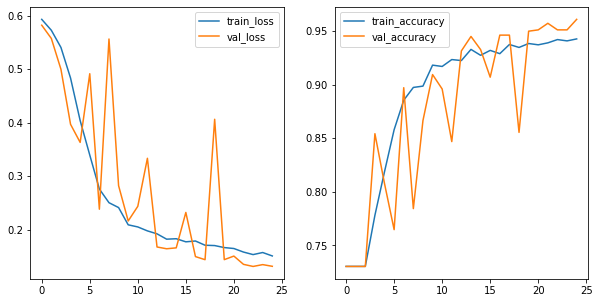

In [42]:
train_loss = cnn_1.history['loss']
train_acc = cnn_1.history['accuracy']
val_loss = cnn_1.history['val_loss']
val_acc = cnn_1.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=cnn_1.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=cnn_1.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=cnn_1.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=cnn_1.epoch, y=val_acc, ax=ax2, label='val_accuracy')


In [43]:

def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))  
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))        #Last layer must be 1 for binary classification 

    model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

    return model

In [44]:
keras_model2 = scikit_learn.KerasClassifier(build_cnn,
                                            epochs=25,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

In [45]:
save_result(cm,'CNN #1')

,Model,RW Score,F1,Recall,Precision,Accuracy
0,CNN #1,0.866,0.874,0.864,0.884,0.931
0,baseline_model,0.861,0.856,0.863,0.850,0.923


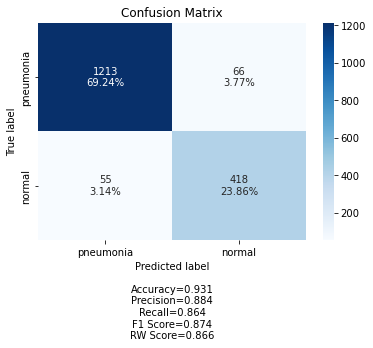

In [46]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 2

For this model, I added another round of Conv2D and MaxPooling layers, and changed the optimizer to "adam"

In [47]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(96, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [48]:
history2 = model2.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/50
103/103 [==============================] - 14s 128ms/step - loss: 0.5128 - accuracy: 0.7549 - val_loss: 0.4897 - val_accuracy: 0.7402
Epoch 2/50
103/103 [==============================] - 13s 127ms/step - loss: 0.2891 - accuracy: 0.8811 - val_loss: 0.1954 - val_accuracy: 0.9167
Epoch 3/50
103/103 [==============================] - 11s 111ms/step - loss: 0.2183 - accuracy: 0.9141 - val_loss: 0.1449 - val_accuracy: 0.9436
Epoch 4/50
103/103 [==============================] - 11s 112ms/step - loss: 0.1590 - accuracy: 0.9377 - val_loss: 0.1154 - val_accuracy: 0.9596
Epoch 5/50
103/103 [==============================] - 13s 127ms/step - loss: 0.1350 - accuracy: 0.9542 - val_loss: 0.1255 - val_accuracy: 0.9632
Epoch 6/50
103/103 [==============================] - 13s 127ms/step - loss: 0.1303 - accuracy: 0.9514 - val_loss: 0.1058 - val_accuracy: 0.9620
Epoch 7/50
103/103 [==============================] - 13s 128ms/step - loss: 0.1109 - accuracy: 0.9603 - val_loss: 0.0941 - val_ac

In [49]:
results_train = model2.evaluate(train_images, train_y)

103/103 [==============================] - 1s 10ms/step - loss: 2.7606e-05 - accuracy: 1.0000


In [50]:
results_test = model2.evaluate(test_images, test_y)

55/55 [==============================] - 1s 10ms/step - loss: 0.3585 - accuracy: 0.9515


<AxesSubplot:>

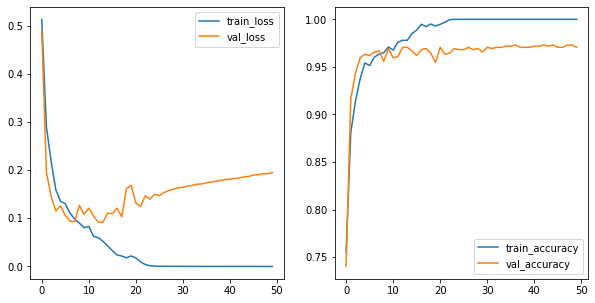

In [51]:
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history2.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history2.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history2.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history2.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [52]:
def build_cnn2():
    model2 = models.Sequential()
    model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))
    
    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Conv2D(96, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Flatten())
    model2.add(layers.Dense(64, activation='relu'))
    model2.add(layers.Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

    return model2

In [53]:
keras_model3 = scikit_learn.KerasClassifier(build_cnn2,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

### Prediction for Confusion Matrix

In [54]:
predictions = model2.predict(x = test_images, steps = 10, verbose=0)

In [55]:
pred_check = np.round(predictions)

In [56]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [57]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [58]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [59]:
save_result(cm, 'CNN #2', )

,Model,RW Score,F1,Recall,Precision,Accuracy
0,CNN #2,0.909,0.910,0.909,0.911,0.951
0,CNN #1,0.866,0.874,0.864,0.884,0.931
0,baseline_model,0.861,0.856,0.863,0.850,0.923


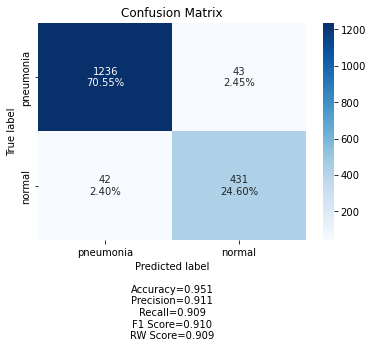

In [60]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 3

For this model, I add two layers of batch normalization and a 10% dropout. Also added one more layer of Conv2D and MaxPooling.

In [61]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(Dropout(0.1))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [62]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)         

In [63]:
print(f'trainsize {train_size}, validation size {validation_size}')

trainsize 3272, validation size 816


In [64]:
history3 = model3.fit(train_images,  #Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches
                    train_y,  #Integer or None. Number of samples per gradient update. default to 32. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).  
                    #steps_per_epoch = 100,  #The steps per epoch determines how many steps are done before the model is updated.
                    epochs=50,                       # Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached. 
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/50
103/103 [==============================] - 15s 141ms/step - loss: 0.2536 - accuracy: 0.9028 - val_loss: 0.5468 - val_accuracy: 0.7243
Epoch 2/50
103/103 [==============================] - 14s 136ms/step - loss: 0.1478 - accuracy: 0.9450 - val_loss: 1.0107 - val_accuracy: 0.3039
Epoch 3/50
103/103 [==============================] - 15s 147ms/step - loss: 0.1218 - accuracy: 0.9578 - val_loss: 0.6858 - val_accuracy: 0.6054
Epoch 4/50
103/103 [==============================] - 15s 144ms/step - loss: 0.1183 - accuracy: 0.9575 - val_loss: 0.7674 - val_accuracy: 0.4657
Epoch 5/50
103/103 [==============================] - 14s 140ms/step - loss: 0.1005 - accuracy: 0.9639 - val_loss: 0.2213 - val_accuracy: 0.9142
Epoch 6/50
103/103 [==============================] - 14s 140ms/step - loss: 0.0940 - accuracy: 0.9667 - val_loss: 4.6814 - val_accuracy: 0.7304
Epoch 7/50
103/103 [==============================] - 15s 145ms/step - loss: 0.0842 - accuracy: 0.9688 - val_loss: 1.0449 - val_ac

In [65]:
results_train = model3.evaluate(train_images, train_y)

103/103 [==============================] - 1s 13ms/step - loss: 1.2746e-06 - accuracy: 1.0000


In [66]:
results_test = model3.evaluate(test_images, test_y)

55/55 [==============================] - 1s 13ms/step - loss: 0.4020 - accuracy: 0.9475


In [67]:
results_train

[1.2745512094625155e-06, 1.0]

In [68]:
results_test

[0.4019615948200226, 0.9474886059761047]

<AxesSubplot:>

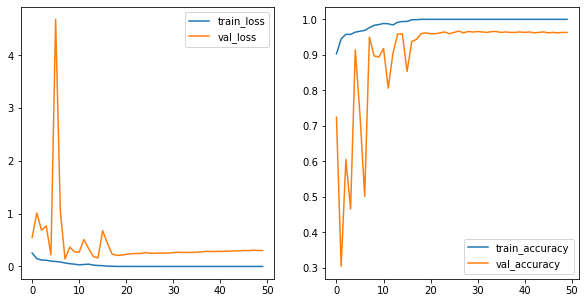

In [69]:
train_loss = history3.history['loss']
train_acc = history3.history['accuracy']
val_loss = history3.history['val_loss']
val_acc = history3.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history3.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history3.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history3.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history3.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [70]:
#model3.save('models/model_3.h5')

In [71]:
def build_cnn3():
    model3 = models.Sequential()

    model3.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model3.add(BatchNormalization())
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model3.add(BatchNormalization())
    model3.add(layers.MaxPooling2D((2, 2)))


    model3.add(layers.Flatten())
    model3.add(layers.Dense(64, activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(layers.Dense(1, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model3

In [72]:
keras_model4 = scikit_learn.KerasClassifier(build_cnn3,
                                            epochs=50,                       # Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached. 
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

### Prediction for Confusion Matrix

In [73]:
predictions = model3.predict(x = test_images, steps = 10, verbose=0)

In [74]:
pred_check = np.round(predictions)

In [75]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

In [76]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [77]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [78]:
save_result(cm, 'CNN #3')

,Model,RW Score,F1,Recall,Precision,Accuracy
0,CNN #2,0.909,0.910,0.909,0.911,0.951
0,CNN #3,0.904,0.903,0.904,0.901,0.947
0,CNN #1,0.866,0.874,0.864,0.884,0.931
0,baseline_model,0.861,0.856,0.863,0.850,0.923


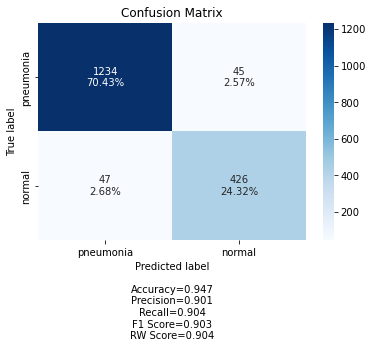

In [79]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 4

For this model, I will add weights

In [80]:
neg = len(os.listdir('re-split_data/train/normal'))
pos = len(os.listdir('re-split_data/train/pneumonia'))
total = neg + pos

In [81]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1} #

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#Weight for class 0: 0.50 --- This is from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#Weight for class 1: 289.44

Weight for class 0: 1.85
Weight for class 1: 0.68


In [82]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))


model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [83]:
history4 = model4.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size,
                    class_weight=class_weight)

Epoch 1/50
103/103 [==============================] - 17s 163ms/step - loss: 0.2515 - accuracy: 0.8994 - val_loss: 0.5301 - val_accuracy: 0.7966
Epoch 2/50
103/103 [==============================] - 17s 164ms/step - loss: 0.1641 - accuracy: 0.9389 - val_loss: 1.4481 - val_accuracy: 0.2696
Epoch 3/50
103/103 [==============================] - 17s 165ms/step - loss: 0.1399 - accuracy: 0.9453 - val_loss: 0.3075 - val_accuracy: 0.8370
Epoch 4/50
103/103 [==============================] - 18s 172ms/step - loss: 0.1224 - accuracy: 0.9514 - val_loss: 0.3145 - val_accuracy: 0.8934
Epoch 5/50
103/103 [==============================] - 20s 192ms/step - loss: 0.1022 - accuracy: 0.9597 - val_loss: 0.2012 - val_accuracy: 0.9179
Epoch 6/50
103/103 [==============================] - 17s 162ms/step - loss: 0.1019 - accuracy: 0.9612 - val_loss: 0.1865 - val_accuracy: 0.9375
Epoch 7/50
103/103 [==============================] - 17s 164ms/step - loss: 0.0882 - accuracy: 0.9685 - val_loss: 2.7809 - val_ac

In [84]:
results_train = model4.evaluate(train_images, train_y)

103/103 [==============================] - 1s 12ms/step - loss: 8.2286e-06 - accuracy: 1.0000


In [85]:
results_test = model4.evaluate(test_images, test_y)

55/55 [==============================] - 1s 12ms/step - loss: 0.3108 - accuracy: 0.9566


In [86]:
results_train

[8.228609658544883e-06, 1.0]

In [87]:
results_test

[0.3107980787754059, 0.956620991230011]

<AxesSubplot:>

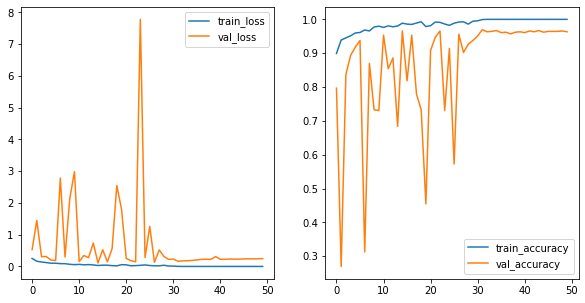

In [88]:
train_loss = history4.history['loss']
train_acc = history4.history['accuracy']
val_loss = history4.history['val_loss']
val_acc = history4.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history4.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history4.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history4.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history4.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [89]:
def build_cnn5():
    model4 = models.Sequential()

    model4.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model4.add(BatchNormalization())
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model4.add(BatchNormalization())
    model4.add(layers.MaxPooling2D((2, 2)))


    model4.add(layers.Flatten())
    model4.add(layers.Dense(64, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(layers.Dense(1, activation='sigmoid'))

    model4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model4

In [90]:
keras_model5 = scikit_learn.KerasClassifier(build_cnn5,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size,
                                            class_weight = class_weight)

In [91]:
predictions = model4.predict(x = test_images, steps = 10, verbose=0)

In [92]:
pred_check = np.round(predictions)

In [93]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [94]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [95]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [96]:
save_result(cm, 'CNN #4')

,Model,RW Score,F1,Recall,Precision,Accuracy
0,CNN #4,0.922,0.919,0.923,0.915,0.957
0,CNN #2,0.909,0.910,0.909,0.911,0.951
0,CNN #3,0.904,0.903,0.904,0.901,0.947
0,CNN #1,0.866,0.874,0.864,0.884,0.931
0,baseline_model,0.861,0.856,0.863,0.850,0.923


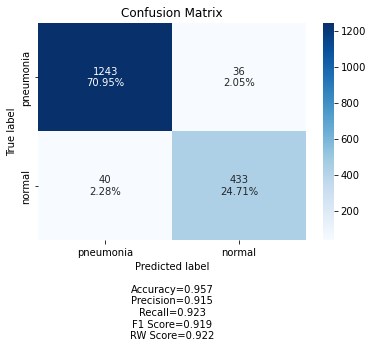

In [97]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

## CNN Model 5: Model 3 with added layer

After observing how the first five models ran,  CNN #2 was the best model due to low standard deviation for the cross validation and high test and train accuracy. I will try adding dropout to help the little bit of overtraining that is occuring

In [98]:
model6 = models.Sequential()

model6.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(32, (4, 4), activation='relu'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))  # new
model6.add(BatchNormalization())                                        # new    
model6.add(Dropout(0.1))                                                # new                   
model6.add(layers.MaxPooling2D((2, 2)))                                     # new

model6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))


model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(Dropout(0.1))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [99]:
history6 = model6.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size,
                    class_weight = class_weight)

Epoch 1/50
103/103 [==============================] - 15s 144ms/step - loss: 0.2241 - accuracy: 0.9034 - val_loss: 1.0929 - val_accuracy: 0.7304
Epoch 2/50
103/103 [==============================] - 15s 145ms/step - loss: 0.1518 - accuracy: 0.9410 - val_loss: 1.4036 - val_accuracy: 0.7304
Epoch 3/50
103/103 [==============================] - 15s 143ms/step - loss: 0.1426 - accuracy: 0.9447 - val_loss: 1.3484 - val_accuracy: 0.7353
Epoch 4/50
103/103 [==============================] - 15s 143ms/step - loss: 0.1083 - accuracy: 0.9581 - val_loss: 0.4689 - val_accuracy: 0.7267
Epoch 5/50
103/103 [==============================] - 16s 155ms/step - loss: 0.1084 - accuracy: 0.9560 - val_loss: 0.4136 - val_accuracy: 0.8199
Epoch 6/50
103/103 [==============================] - 17s 167ms/step - loss: 0.1033 - accuracy: 0.9581 - val_loss: 0.2618 - val_accuracy: 0.8983
Epoch 7/50
103/103 [==============================] - 16s 156ms/step - loss: 0.0957 - accuracy: 0.9630 - val_loss: 0.3147 - val_ac

In [100]:
results_train = model6.evaluate(train_images, train_y)

103/103 [==============================] - 1s 12ms/step - loss: 0.2668 - accuracy: 0.9364


In [101]:
results_test = model6.evaluate(test_images, test_y)

55/55 [==============================] - 1s 12ms/step - loss: 0.4768 - accuracy: 0.9138


<AxesSubplot:>

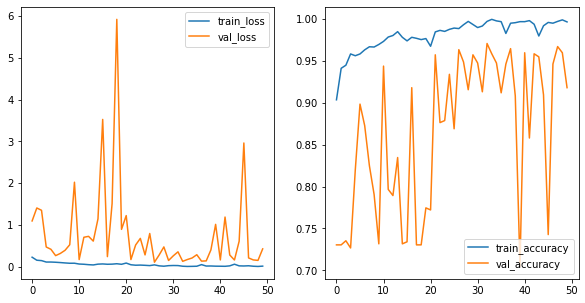

In [102]:
train_loss = history6.history['loss']
train_acc = history6.history['accuracy']
val_loss = history6.history['val_loss']
val_acc = history6.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history6.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history6.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history6.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history6.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [103]:
def build_cnn6():
    model6 = models.Sequential()

    model6.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))  # new
    model6.add(BatchNormalization())                                        # new    
    model6.add(Dropout(0.1))                                                # new                   
    model6.add(layers.MaxPooling2D((2, 2)))                                     # new

    model6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))


    model6.add(layers.Flatten())
    model6.add(layers.Dense(64, activation='relu'))
    model6.add(Dropout(0.1))
    model6.add(layers.Dense(1, activation='sigmoid'))

    model6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model6

In [104]:
keras_model6 = scikit_learn.KerasClassifier(build_cnn6,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size,
                                            class_weight = class_weight)

### Prediction for Confusion Matrix

In [105]:
predictions = model6.predict(x = test_images, steps = 10, verbose=0)

In [106]:
pred_check = np.round(predictions)

In [107]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [108]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [109]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [110]:
save_result(cm, 'CNN #6')

,Model,RW Score,F1,Recall,Precision,Accuracy
0,CNN #4,0.922,0.919,0.923,0.915,0.957
0,CNN #2,0.909,0.910,0.909,0.911,0.951
0,CNN #3,0.904,0.903,0.904,0.901,0.947
0,CNN #1,0.866,0.874,0.864,0.884,0.931
0,baseline_model,0.861,0.856,0.863,0.850,0.923
0,CNN #6,0.935,0.815,0.971,0.702,0.914


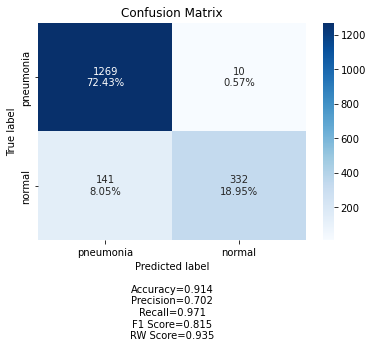

In [111]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

## VGG Model

In [237]:
train_path = 're-split_data/train'
valid_path = 're-split_data/validation'
test_path = 're-split_data/test'

In [238]:
train_batches2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32)
valid_batches2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224),  batch_size=32)
test_batches2 = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224),  batch_size=32, shuffle=False)

Found 3272 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.


In [239]:
# create the data sets
train_images2, train_labels2 = next(train_batches2)
test_images2, test_labels2 = next(test_batches2)
valid_images2, valid_labels2 = next(valid_batches2)

train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
valid_img2 = valid_images2.reshape(valid_images2.shape[0], -1)

print(train_img2.shape)
print(test_img2.shape)
print(valid_img2.shape)

(32, 150528)
(32, 150528)
(32, 150528)


In [240]:
train_y2 = np.reshape(train_labels2[:,0], (32,1))
test_y2 = np.reshape(test_labels2[:,0], (32,1))
valid_y2 = np.reshape(valid_labels2[:,0], (32,1))
print(train_y2.shape)
print(test_y2.shape)
print(valid_y2.shape)

(32, 1)
(32, 1)
(32, 1)


In [241]:
# get all the data in the directory split/test , and reshape them
'''
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/train',
        target_size=(64, 64), batch_size = train_size) 

test_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/test',
        target_size=(64, 64), batch_size = test_size, shuffle= False) 

valid_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/validation',
        target_size=(64, 64), batch_size = validation_size)
'''

"\ntrain_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/train',\n        target_size=(64, 64), batch_size = train_size) \n\ntest_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/test',\n        target_size=(64, 64), batch_size = test_size, shuffle= False) \n\nvalid_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/validation',\n        target_size=(64, 64), batch_size = validation_size)\n"

In [242]:
# create the data sets
'''
train_images2, train_labels2 = next(train_generator)
test_images2, test_labels2 = next(test_generator)
valid_images2, valid_labels2 = next(valid_generator)
'''

'\ntrain_images2, train_labels2 = next(train_generator)\ntest_images2, test_labels2 = next(test_generator)\nvalid_images2, valid_labels2 = next(valid_generator)\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

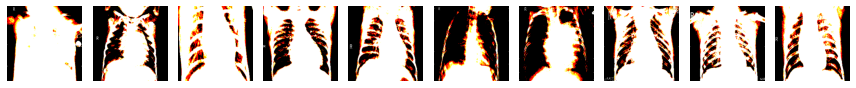

In [243]:
show_images(train_images2)

In [244]:
'''
train_img2 = train_images2.reshape(train_images2.shape[0], -1)
test_img2 = test_images2.reshape(test_images2.shape[0], -1)
valid_img2 = valid_images2.reshape(valid_images2.shape[0], -1)

print(train_img2.shape)
print(test_img2.shape)
print(valid_img2.shape)
'''

'\ntrain_img2 = train_images2.reshape(train_images2.shape[0], -1)\ntest_img2 = test_images2.reshape(test_images2.shape[0], -1)\nvalid_img2 = valid_images2.reshape(valid_images2.shape[0], -1)\n\nprint(train_img2.shape)\nprint(test_img2.shape)\nprint(valid_img2.shape)\n'

In [245]:
'''
train_y2 = np.reshape(train_labels2[:,0], (train_size,1))
test_y2 = np.reshape(test_labels2[:,0], (test_size,1))
valid_y2 = np.reshape(valid_labels2[:,0], (validation_size,1))

print(train_y2.shape)
print(test_y2.shape)
print(valid_y2.shape)
'''

'\ntrain_y2 = np.reshape(train_labels2[:,0], (train_size,1))\ntest_y2 = np.reshape(test_labels2[:,0], (test_size,1))\nvalid_y2 = np.reshape(valid_labels2[:,0], (validation_size,1))\n\nprint(train_y2.shape)\nprint(test_y2.shape)\nprint(valid_y2.shape)\n'

In [246]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

vgg16_model.summary()

In [247]:
# create new model of type sequential, then iterate over each of layers in vgg model (save last),
#  add layers to sequential.
#model_VGG = Sequential()
#for layer in vgg16_model.layers[:-1]:
   # model_VGG.add(layer)

In [248]:
#for layer in model_VGG.layers:
   # layer.trainable = False

In [249]:
#model_VGG.add(Dense(units=2, activation='sigmoid'))

In [250]:
#model_VGG.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [251]:
#vgg_hist = model_VGG.fit(x=train_batches,
 #                       steps_per_epoch = len(train_batches),
 #                       validation_data=valid_batches,
  #                      validation_steps = len(valid_batches),
 #                       epochs=7)

In [252]:
#os.mkdir('models')

In [253]:
#model_VGG.save('models/VGG_model.h5')

In [254]:
# load model
from tensorflow.keras.models import load_model
new_model = load_model('models/VGG_model.h5')

In [255]:
model_VGG = new_model

In [256]:
test_images2, test_labels2= next(test_batches2)

In [257]:
predictions = model_VGG.predict(x=test_batches2, steps=len(test_batches2), verbose = 0)

In [258]:
y_pred = np.argmax(predictions, axis = 1)

In [259]:
y_true = test_batches2.classes

In [260]:
# Confusion Matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
cm

array([[ 421,   52],
       [  40, 1239]], dtype=int64)

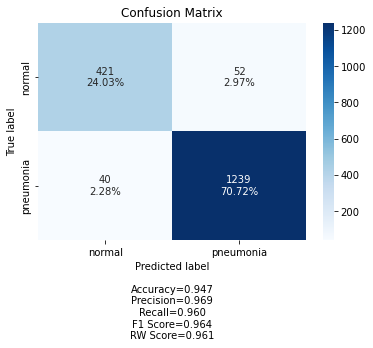

In [261]:
cm_plot_labels = ['normal', 'pneumonia']
make_confusion_matrix(cm, categories=cm_plot_labels, title='Confusion Matrix')

In [262]:
# Sanity Check

tp = cm[1,1]
fn = cm[0,1]
recall = tp / (tp + fn)
recall

0.959721146398141

## Expaining The Final Model With LIME

In [263]:
import lime
from lime import lime_image

In [264]:
explainer = lime_image.LimeImageExplainer()

### Here, I am checking the labels and predictions of various images, then viewing the decision-making weights using LIME Explinations.
An explanation is a local linear approximation of the models behavior. While the model may be complex globally, it is simple(r) to approximate it around the vicinity of a particular insance (github.com/marcotcr/lime)

In [265]:
from skimage.segmentation import mark_boundaries

In [266]:
def check_label(train_images_num):
    img1 = train_images[train_images_num]
    img = train_labels[train_images_num][0]
    if img == 0:
        return 'pneumonia'
    else:
        return 'normal'

In [268]:
check_label(0)

'pneumonia'

In [271]:
img = train_images[3].reshape(1,64, 64, 3)
pred = model4.predict(img)
pred = np.round(pred)
pred


array([[0.]], dtype=float32)

In [273]:
img = train_images[20].reshape(1,64,64,3)
pred = model4.predict(img)
pred

array([[6.1722814e-11]], dtype=float32)

In [274]:
def check_prediction(train_images_num):
    img = train_images[train_images_num].reshape(1,64,64,3)
    pred = model4.predict(img)
    if pred[0][0] < 0.5:
        return 'pneumonia'
    else:
        return 'normal'
        

In [275]:
def plot_image_preds(train_images_num):
    img = train_images[train_images_num].reshape(1,64,64,3)
    pred = model4.predict(img)
    f, ax = plt.subplots(figsize=(10,8))
    plt.imshow(img[0])
    plt.title('Prediction: ' + check_prediction(train_images_num) + '\n' + 'Label: ' + check_label(train_images_num), fontsize=20)
    plt.show()

In [276]:
def plot_explanation(exp):
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, hide_rest=False)
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title('Explanation for classification', fontsize=20)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    

In [277]:
# Plots the positive and negative explanations for the label

def plot_pos_neg_explanation(exp):
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, hide_rest=False)
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title('Explanation for classification ', fontsize=20)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [278]:
#Plots explanation with minimum weights

def plot_with_weights(exp, mw): # mw is the minimum weight
    temp, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False, hide_rest=False, min_weight = mw)
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title('Explanation - with weights - for classification ', fontsize=18)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [279]:
# Plots the heatmap of the explanation

def plot_explanation_heatmap(exp):
    ind =  exp.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(exp.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
    f, ax = plt.subplots(figsize=(8, 8)) 
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.title('Heatmap for classification ', fontsize=20)
    plt.colorbar()

In [285]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation1 = explainer.explain_instance(train_images[1].astype("double"), model4.predict, top_labels=2, hide_color=0, num_samples=10000)

100%|██████████| 10000/10000 [00:45<00:00, 221.94it/s]


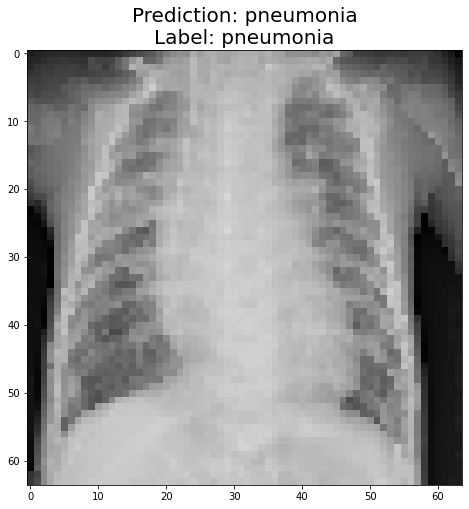

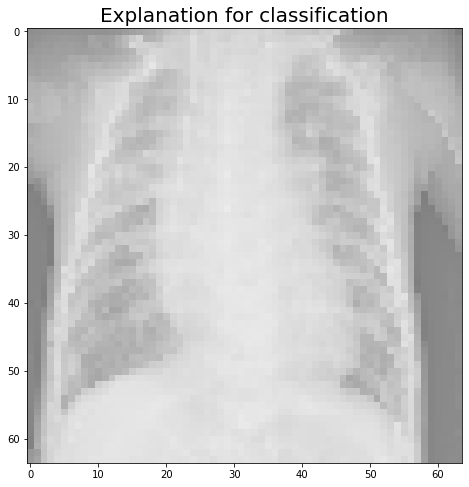

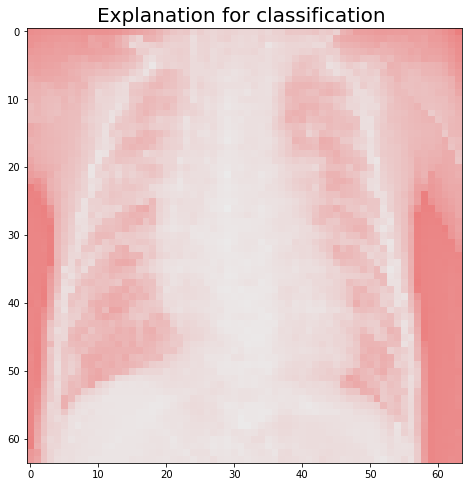

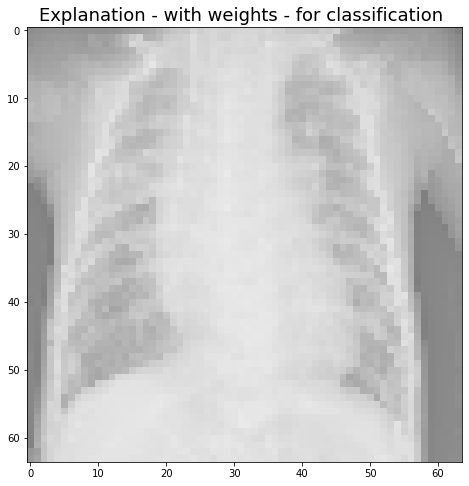

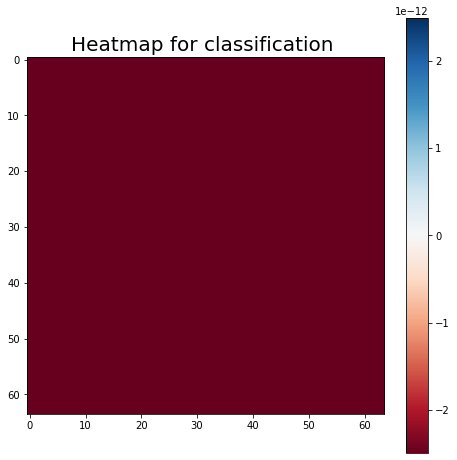

In [286]:
plot_image_preds(1)
plot_explanation(explanation1)
plot_pos_neg_explanation(explanation1)
plot_with_weights(explanation1, 0.5)
plot_explanation_heatmap(explanation1)

### Image 2

In [ ]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation2 = explainer.explain_instance(train_images[12].astype("double"), model4.predict, top_labels = 2, hide_color=0, num_samples=10000)

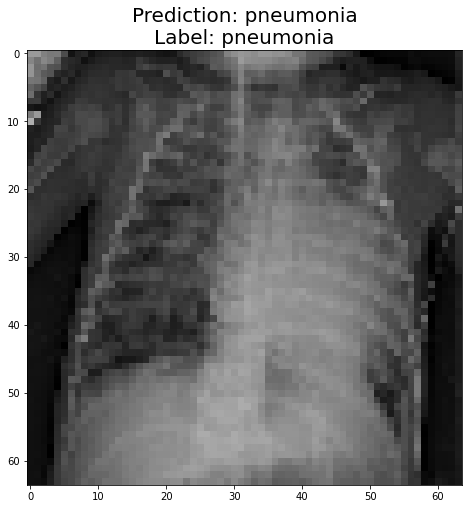

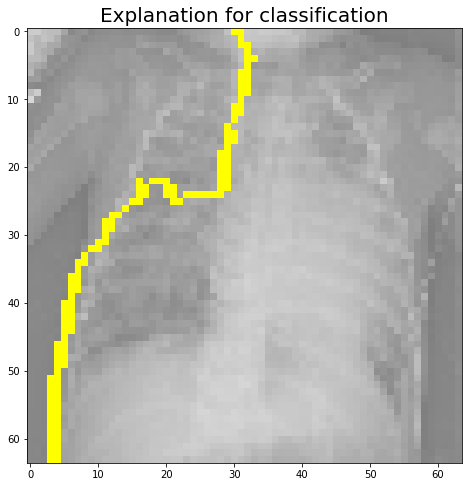

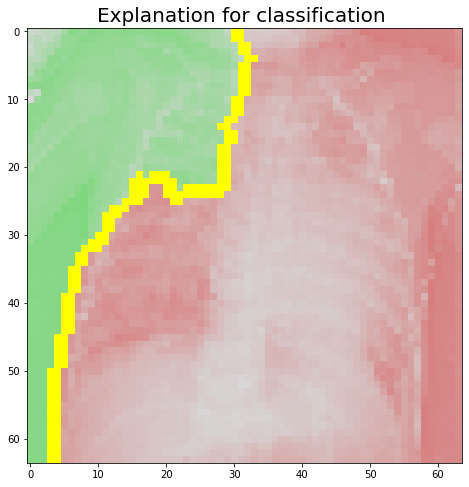

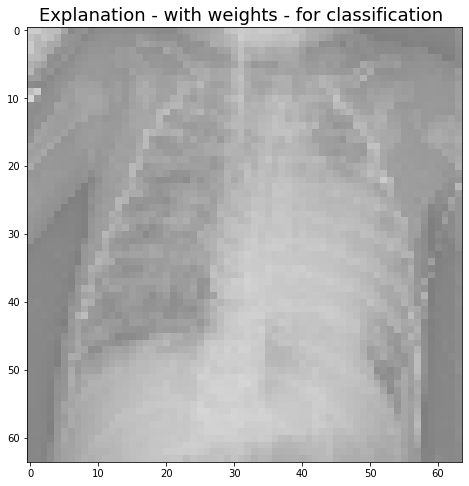

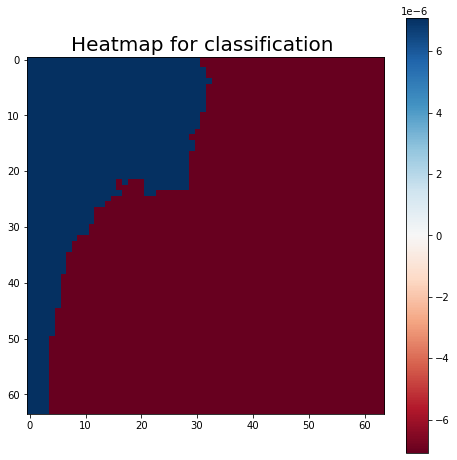

In [ ]:
plot_image_preds(12)
plot_explanation(explanation2)
plot_pos_neg_explanation(explanation2)
plot_with_weights(explanation2, 0.2)
plot_explanation_heatmap(explanation2)

### Image 3: A Positive Image
The first one I find

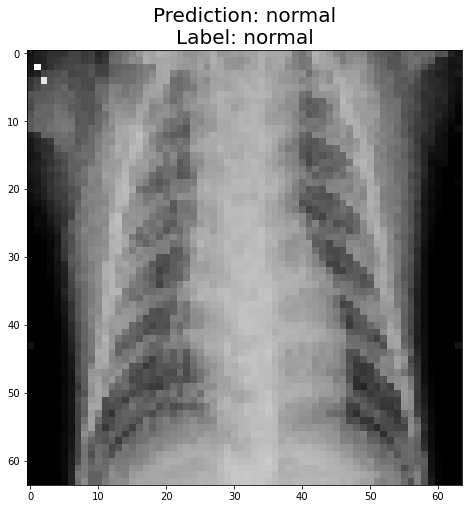

In [ ]:
plot_image_preds(723)

In [ ]:
explanation3 = explainer.explain_instance(train_images[723].astype("double"), model4.predict, top_labels = 2, hide_color=0, num_samples=10000)

100%|██████████| 10000/10000 [00:44<00:00, 225.18it/s]


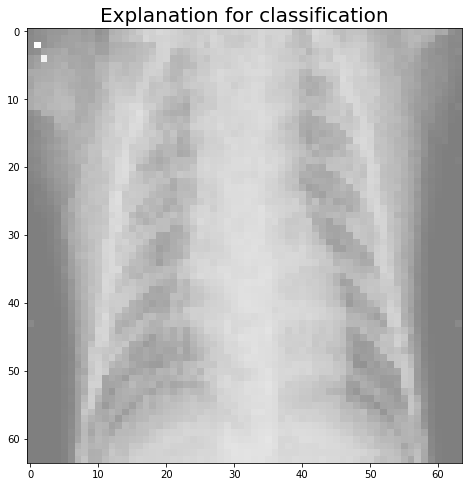

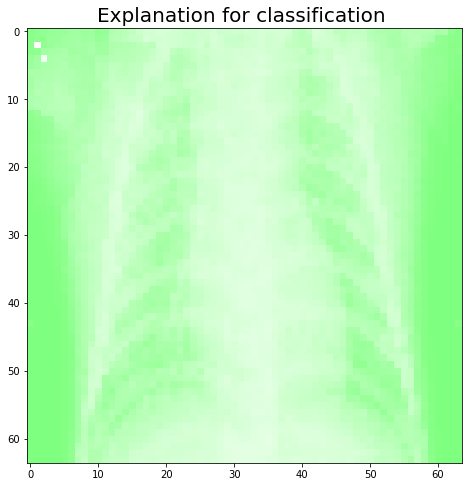

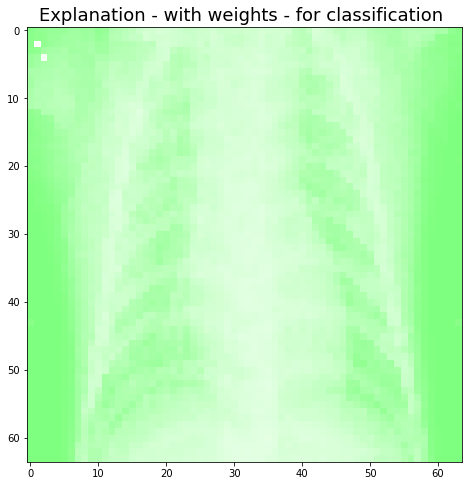

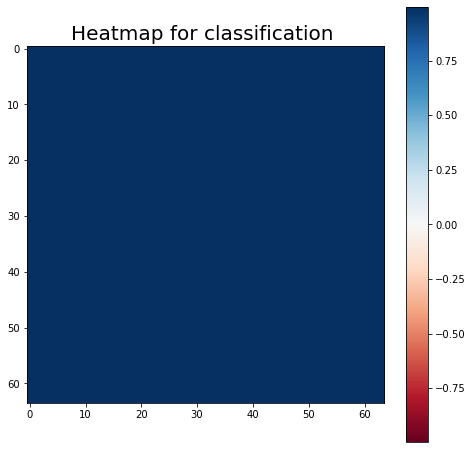

In [ ]:
plot_explanation(explanation3)
plot_pos_neg_explanation(explanation3)
plot_with_weights(explanation3, 0.2)
plot_explanation_heatmap(explanation3)


### Image 4

In [ ]:
explanation4 = explainer.explain_instance(train_images[804].astype("double"), model4.predict, top_labels = 2, hide_color=0, num_samples=10000)

100%|██████████| 10000/10000 [00:44<00:00, 223.34it/s]


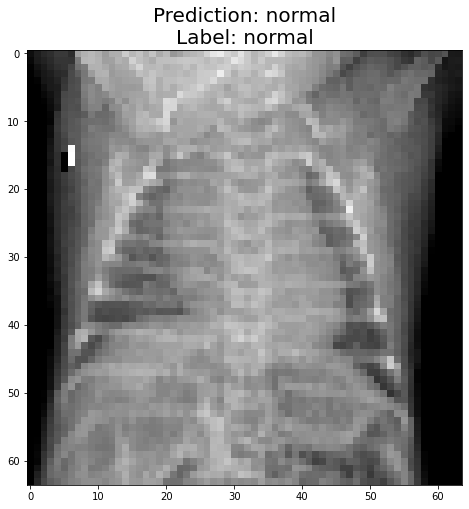

In [ ]:
plot_image_preds(804)

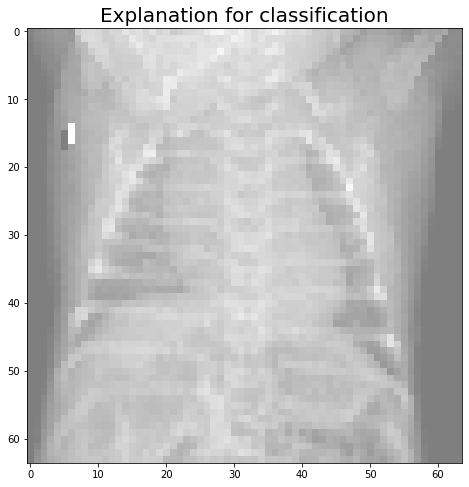

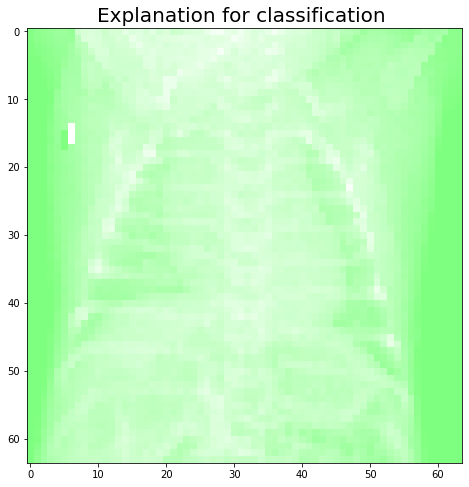

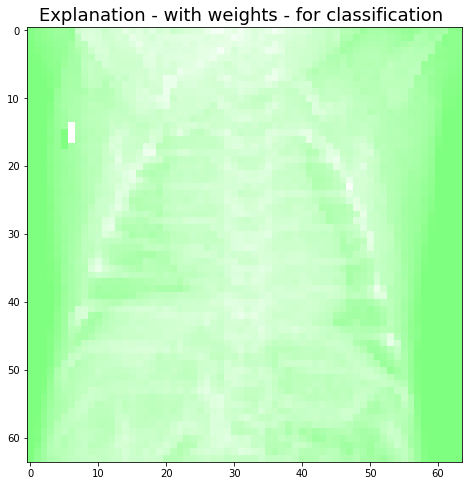

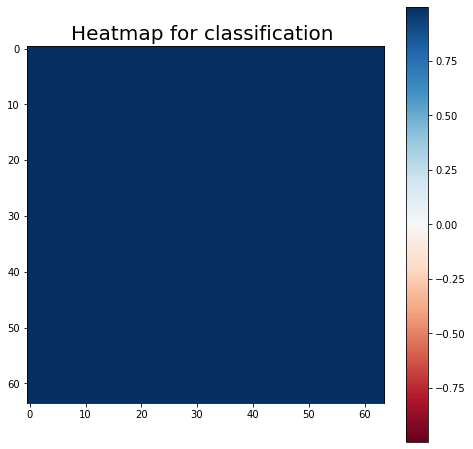

In [ ]:
plot_explanation(explanation4)
plot_pos_neg_explanation(explanation4)
plot_with_weights(explanation4, 0.2)
plot_explanation_heatmap(explanation4)

### Image 5

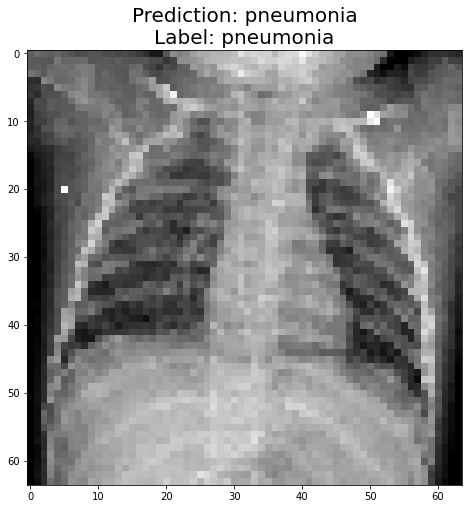

In [ ]:
plot_image_preds(233)

In [ ]:
explanation5 = explainer.explain_instance(train_images[233].astype("double"), model4.predict, top_labels = 2, hide_color=0, num_samples=10000)

100%|██████████| 10000/10000 [00:42<00:00, 235.76it/s]


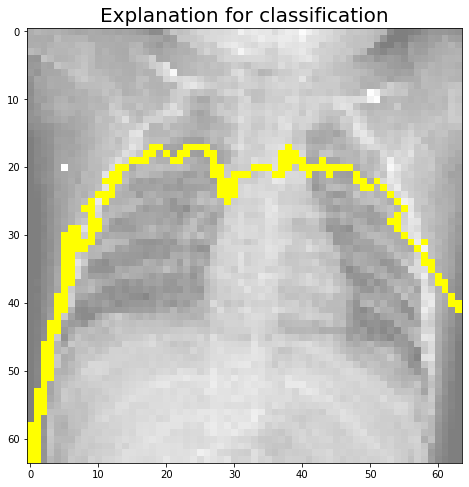

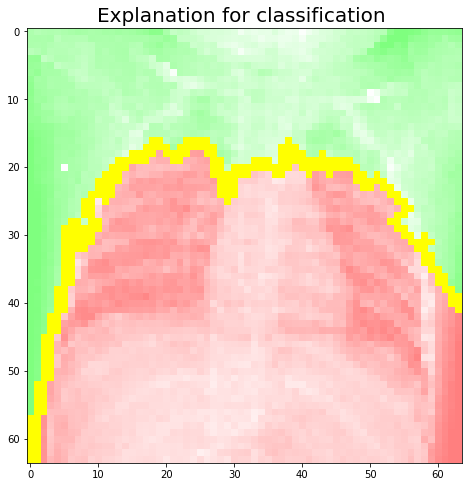

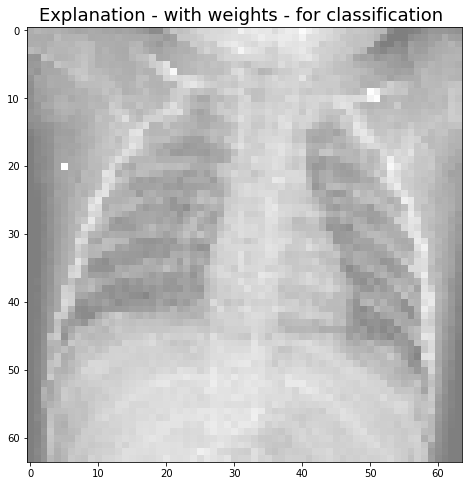

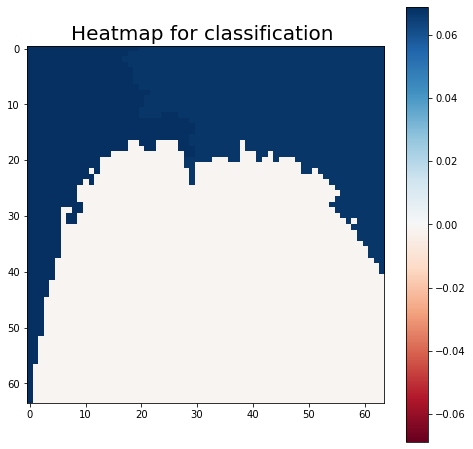

In [ ]:
plot_explanation(explanation5)
plot_pos_neg_explanation(explanation5)
plot_with_weights(explanation5, 0.2)
plot_explanation_heatmap(explanation5)

### Image 6

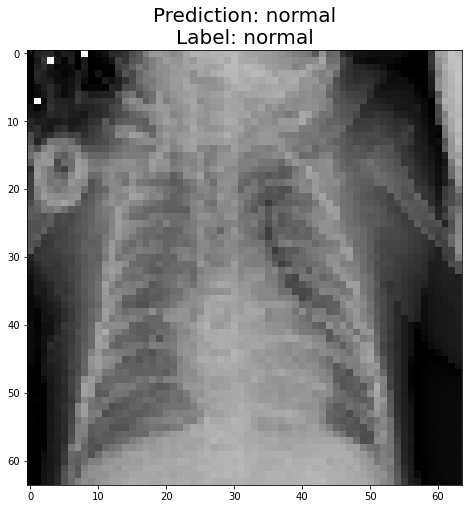

In [ ]:
plot_image_preds(414)

In [ ]:
# Image 123 is pneumonia
explanation6 = explainer.explain_instance(train_images[123].astype("double"), model4.predict, top_labels = 2, hide_color=0, num_samples=10000)


100%|██████████| 10000/10000 [00:41<00:00, 240.08it/s]


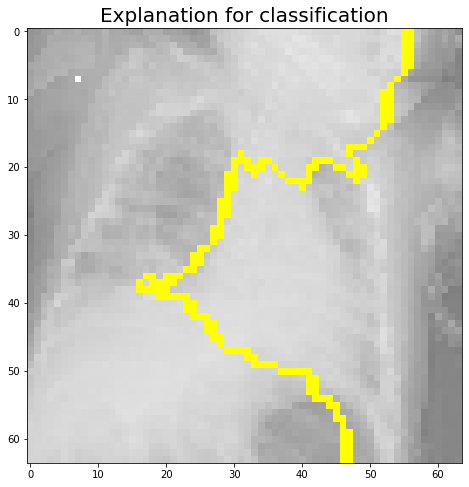

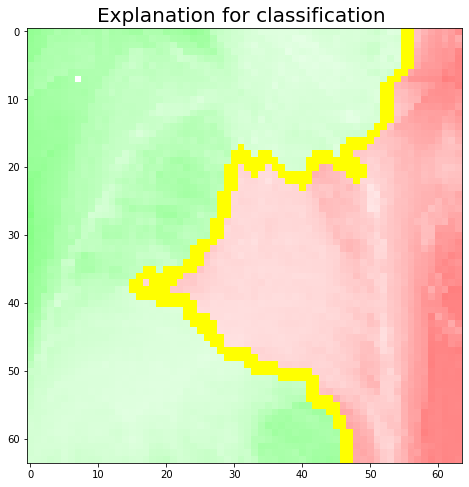

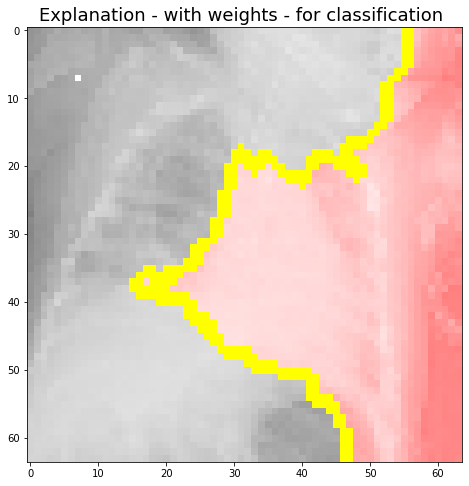

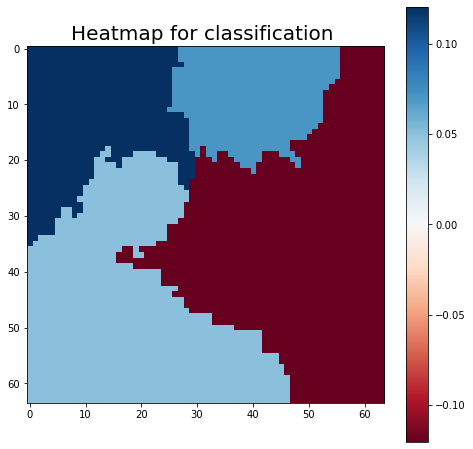

In [ ]:
plot_explanation(explanation6)
plot_pos_neg_explanation(explanation6)
plot_with_weights(explanation6, 0.2)
plot_explanation_heatmap(explanation6)

## Conclusion

The VGG Model had the best F-beta score, making it the best model for this project. 



### Final Results

The final result included 1,239 true positives, 421 true negatives, 40 false negatives, and 52 false positives. 

The final recall-weighted F-score (or, F-beta score) was .961. 

The total accuracy was 94.7 percent. 

Recall is the number of true positives divided by the total number of elements that actually belong to the positive class -i.e., true positives plus false negatives. 

- Recall equaled  .960.
- Precision equaled .969.
- The F1 Score equaled .964.

In product terms, this means that we could expect the model to correctly pick if an individual has pneumonia based on their x-ray 91.4 percent of the time. Further, it has a much higher false positive rate than false negative, as it was designed to.

If I could further this project, I would  attempt further data augmentation. The data augmentation I attempted did not improve the performance of the model, although that portion of the model was cut out for brevity, along with numerous other versions of the CNNs. 

Thank you.